# Spot the Difference: Real vs. StyleGAN-generated Faces
CSCI 1430: Computer Vision

Professor James Tompkin

*Colden Bobowick, Spencer Dellenbaugh, Alexander Halpin*

May 10, 2023

## Setup
The following block consists of imports, installs, and downloads essential to run the code.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications
!pip install lime

In [ ]:
import time
import os
import json
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers.legacy import Adam

from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix
import seaborn as sns

from google.colab import files

from pathlib import Path

import dlib
import cv2
import tqdm
import random


In [ ]:
os.environ['KAGGLE_USERNAME'] = "OMITTED FOR SUBMISSION"
os.environ['KAGGLE_KEY'] = "OMITTED FOR SUBMISSION"
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

In [ ]:
%%capture
!mkdir /content/data
!unzip 140k-real-and-fake-faces.zip -d /content/data

## Eye Cropping with CV2 HAAR Cascade
The HAAR Cascade feature extractor was the first attempt at extracting eyes from the face images. The resulting accuracy was unsatisfactory, so the process was switched to the Dlib face extractor.

In [ ]:
# Set paths to input and output directories
input_dir = '/content/data/real_vs_fake/real-vs-fake/train/fake'
output_dir = '/content/drive/My Drive/cropped/train/fake'

# Load face and eye cascade classifiers
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/haar xmls/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/haar xmls/haarcascade_eye.xml')

# Loop over each image in the input directory
for filename in tqdm.tqdm(os.listdir(input_dir)):
  if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
    # Load image using OpenCV
    image_path = os.path.join(input_dir, filename)
    image = cv2.imread(image_path)

    # Convert image to grayscale for faster processing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Loop over each face and crop the eyes
    for (x, y, w, h) in faces:
      roi_gray = gray[y:y+h, x:x+w]
      roi_color = image[y:y+h, x:x+w]
      eyes = eye_cascade.detectMultiScale(roi_gray)
      print(len(eyes))
      for (ex, ey, ew, eh) in eyes:
        eye = roi_color[ey:ey+eh, ex:ex+ew]

        # Save cropped eye image to Google Drive
        cropped_eye_path = os.path.join(output_dir, f'{filename.split(".")[0]}_eye_{ex}_{ey}.jpg')
        cv2.imwrite(cropped_eye_path, eye)

## Dlib Eye Extractor
The Dlib Eye Extractor, as implemented in [this](https://doi.org/10.3389/frsip.2022.918725) paper. Estimated to have near-perfect accuracy, since 19,994 eyes were detected out of 10,000 testing files.

In [ ]:
# Set paths to input and output directories
input_dir = '/content/data/real_vs_fake/real-vs-fake/train/fake'
output_dir = '/content/cropped/content/cropped/train/fake'

# Load dlib face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/haar xmls/shape_predictor_68_face_landmarks.dat')

for filename in tqdm.tqdm(os.listdir(input_dir)):
  if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
    image_path = os.path.join(input_dir, filename)
    image = cv2.imread(image_path)

    faces = detector(image)

    # Loop over each face and crop the eyes
    for face in faces:
      landmarks = predictor(image, face)
      left_eye = [(landmarks.part(36).x + landmarks.part(39).x) // 2, (landmarks.part(36).y + landmarks.part(39).y) // 2]
      right_eye = [(landmarks.part(42).x + landmarks.part(45).x) // 2, (landmarks.part(42).y + landmarks.part(45).y) // 2]

      # Calculate the distance between the eyes
      distance = abs(left_eye[0] - right_eye[0])

      # Crop the eyes from the image
      left_eye_crop = image[left_eye[1] - distance//2:left_eye[1] + distance//2, left_eye[0] - distance//2:left_eye[0] + distance//2]
      right_eye_crop = image[right_eye[1] - distance//2:right_eye[1] + distance//2, right_eye[0] - distance//2:right_eye[0] + distance//2]

      # Save cropped eye images dir
      left_eye_path = os.path.join(output_dir, f'{filename.split(".")[0]}_left_eye.jpg')
      right_eye_path = os.path.join(output_dir, f'{filename.split(".")[0]}_right_eye.jpg')
      try:
        cv2.imwrite(left_eye_path, left_eye_crop)
      except:
        print(f"\nImage {left_eye_path} could not be created")
      try:
        cv2.imwrite(right_eye_path, right_eye_crop)
      except:
        print(f"\nImage {right_eye_path} could not be created")

In [ ]:
!zip -r /cropped_full.zip /content/cropped/content/cropped

In [ ]:
files.download('/cropped_full.zip')

In [ ]:
!unzip /content/cropped.zip -d /content/cropped

## Convolutional Neural Network
The following is the code that was used to obtain a 93% accuracy on GAN-generated image detection. It utilizes pretrained vgg16 weights, which help extract facial features.

In [ ]:
# Loads training and validation datasets

image_size = 256
batch_size = 32
data_base_path = '/content/data/real_vs_fake/real-vs-fake'

train_ds = keras.utils.image_dataset_from_directory(
    directory=f'{data_base_path}/train',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(image_size, image_size))

val_ds = keras.utils.image_dataset_from_directory(
    directory=f'{data_base_path}/valid',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(image_size, image_size))

In [ ]:
def make_model(cnn_type, image_size):

    # input layer
    input_layer = keras.Input(shape=(image_size, image_size, 3))

    # augment operations
    augment_block = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
            layers.RandomBrightness(0.3),
            layers.RandomContrast(0.2),
        ]
    )

    augment_block.trainable = False


    # feature extractor
    feature_block = VGGFace(
                        model=cnn_type,
                        include_top=False,
                        input_shape=(image_size, image_size, 3),
                        pooling='avg'
                    )
    feature_block.trainable = False

    # classification layers
    classifier_block = keras.Sequential(
        [
            layers.Dense(512),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.05),
            layers.Dense(256),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.05),
            layers.Dense(2, activation='softmax')
        ]
    )


    # compose full model
    full_model = keras.Sequential(
        [
            input_layer,
            augment_block,
            feature_block,
            classifier_block
        ]
    )

    return full_model

In [ ]:
fake_detector_model = make_model('vgg16', image_size)

In [ ]:
fake_detector_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
training_history = fake_detector_model.fit(
    train_ds,
    batch_size = batch_size,
    epochs=10,
    validation_data=val_ds,
)

## Siamese Neural Network
Below is the attempt at a Siamese Neural Network (SNN). The method ```make_pair_generator()``` was intended to match left eye files with the correct right eye files, label them by directory, and return a generator for use in the SNN. This was done to circumvent a memory issue with loading all of the eye images at once.



In [ ]:
!unzip '/content/drive/MyDrive/CSCI 1430 Term Project/cropped_full.zip' -d /content

In [ ]:
def make_pair_generator(dir, image_size, batch_size):
    real_dir = os.path.join(dir, "real")
    fake_dir = os.path.join(dir, "fake")

    real_pairs = match_eyes(real_dir, mode="load", path="/content/1683586881_tuples.json") # {identifier -> (left eye, right eye, label)}
    print(f"{len(real_pairs)} real pairs found for dir {real_dir}")

    fake_pairs = match_eyes(fake_dir, mode="load", path="/content/1683587325_tuples.json") # {identifier -> (left eye, right eye, label)}
    print(f"{len(fake_pairs)} fake pairs found for dir {fake_dir}")

    real_pairs.update(fake_pairs)
    pairs = real_pairs
    print(f"{len(pairs)} total pairs found")

    while True:
        batch_left_eye = []
        batch_right_eye = []
        batch_labels = []

        for i in range(batch_size):
            # choose a random image file
            pair = pairs[random.choice(list(pairs.keys()))]
            left_eye_file, right_eye_file, label = pair

            left_eye = cv2.imread(left_eye_file)
            right_eye = cv2.imread(right_eye_file)
            left_eye = cv2.resize(left_eye, (image_size, image_size))
            right_eye = cv2.resize(right_eye, (image_size, image_size))
            left_eye = left_eye / 255.0
            right_eye = right_eye / 255.0

            batch_left_eye.append(left_eye)
            batch_right_eye.append(right_eye)
            batch_labels.append(label)

        batch_left_eye = np.array(batch_left_eye)
        batch_right_eye = np.array(batch_right_eye)
        batch_labels = np.array(batch_labels)

        # convert the labels to one-hot encoding
        batch_labels = keras.utils.to_categorical(batch_labels, num_classes=2)

        yield [batch_left_eye, batch_right_eye], batch_labels

def match_eyes(eye_dir, mode="find", path="None"):
  '''matches left eye with right eye in a given directory and returns the tuples'''
  if mode == 'find':
    eye_files = os.listdir(eye_dir)
    matching_pairs = {}
    label = 0 if 'fake' in eye_dir else 1 # REAL IS 1, FAKE IS 0
    for file in tqdm.tqdm(eye_files):
      if 'left_eye' in file:
          identifier = file.split('_')[0]
          matching_right_file = [f for f in eye_files if f.startswith(identifier) and 'right_eye' in f]
          if matching_right_file:
              matching_pairs[identifier] = (os.path.join(eye_dir, file), os.path.join(eye_dir, matching_right_file[0]), label)

    with open(f"{int(time.time())}_tuples.json", "w") as f:
        json.dump(matching_pairs, f)
  elif mode == 'load':
    with open(path, "r") as f:
        matching_pairs = json.load(f)

  return matching_pairs

In [ ]:
image_size = 71
batch_size = 32
train_dir = '/content/content/cropped/content/cropped/train'
val_dir = '/content/content/cropped/content/cropped/valid'

train_generator = make_pair_generator(dir, image_size, batch_size)
val_generator = make_pair_generator(dir, image_size, batch_size)

In [ ]:
def make_model(image_size):

    # input layer
    left_eye_input_layer = keras.Input(shape=(image_size, image_size, 3), name='left_eye_input')
    right_eye_input_layer = keras.Input(shape=(image_size, image_size, 3), name='right_eye_input')

    # augment operations
    augment_block = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
            layers.RandomBrightness(0.3),
            layers.RandomContrast(0.2),
        ]
    )

    augment_block.trainable = False

    # feature extractor
    feature_block = Xception(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))

    feature_block.trainable = False

    # define the siamese network that takes in the left and right eye inputs and passes them through the feature extractor
    left_eye_features = feature_block(left_eye_input_layer)
    right_eye_features = feature_block(right_eye_input_layer)
    merged_features = layers.Concatenate()([left_eye_features, right_eye_features])


    # classification layers
    classifier_block = keras.Sequential(
        [
            layers.Dense(512),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.05),
            layers.Dense(256),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.05),
            layers.Dense(2, activation='softmax')
        ]
    )


    # compose full model
    full_model = Model(inputs=[left_eye_input_layer, right_eye_input_layer], outputs=classifier_block(merged_features))

    return full_model

In [ ]:
fake_detector_model = make_model(image_size)

In [ ]:
fake_detector_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

Unfortunately, an ```InvalidArgumentError: Graph execution error``` could not be solved due to the time constraints of the project.

In [ ]:
training_history = fake_detector_model.fit(
    train_generator,
    batch_size = batch_size,
    epochs=3,
    validation_data=val_generator,
)

## Run Evaluation from Checkpoint

In [16]:
import os
from tensorflow import keras
import json

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
kaggle_api = "/content/drive/MyDrive/kaggle.json"
with open(kaggle_api, 'r') as file:
    json_data = json.load(file)

os.environ['KAGGLE_USERNAME'] = json_data["username"]
os.environ['KAGGLE_KEY'] = json_data["key"]
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

140k-real-and-fake-faces.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
%%capture
!mkdir /content/data
!unzip 140k-real-and-fake-faces.zip -d /content/data

In [19]:
image_size = 256
batch_size = 32
data_base_path = '/content/data/real_vs_fake/real-vs-fake'
chkpt_base_path = '/content/drive/MyDrive/checkpoints'

val_ds = keras.utils.image_dataset_from_directory(
    directory=f'{data_base_path}/valid',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(image_size, image_size))

pretrained_model = keras.models.load_model(f'{chkpt_base_path}/fake_detector_model-1683593315')

Found 20000 files belonging to 2 classes.


In [20]:
evaluation = pretrained_model.evaluate(
    val_ds,
    batch_size=batch_size
)

625/625 [==============================] - 107s 170ms/step - loss: 0.1762 - accuracy: 0.9292


In [21]:
print(f'Accuracy: {evaluation[1]*100:.02f}%')

Accuracy: 92.92%


## Evaluation
The following sections are used to save model weights as a checkpoint and evaluate different aspects of a given checkpoint.

In [ ]:
chkpt_base_path = '/content/drive/MyDrive/checkpoints'

In [ ]:
os.makedirs(chkpt_base_path, exist_ok=True)

fake_detector_model.save(f'{chkpt_base_path}/fake_detector_model-{int(time.time())}')

In [ ]:
evaluation = fake_detector_model.evaluate(
    val_ds,
    batch_size=batch_size
)

In [ ]:
pretrained_model = keras.models.load_model(f'{chkpt_base_path}/fake_detector_model-1682441368')
evaluation = pretrained_model.evaluate(
    val_ds,
    batch_size=batch_size
)

### Saliency Map
Constructs sample saliency maps for a model checkpoint. Helpful for determining what spatial locations are most important to the CNN.

In [ ]:
def get_saliency_maps(model, sample_batch, sample_labels):
    with tf.GradientTape() as tape:
      tape.watch(sample_images)
      predictions = pretrained_model(sample_images)
      fake_loss = tf.gather(predictions, sample_labels, axis=1, batch_dims=1)

    gradient = tape.gradient(fake_loss, sample_images)
    gradient_maxs = tf.reduce_max(np.abs(gradient), axis=3)
    grad_min_vals, grad_max_vals = np.min(gradient_maxs, axis=(1,2)), np.max(gradient_maxs, axis=(1,2))

    grad_mins_ed = np.expand_dims(grad_min_vals, (1,2))
    grad_maxs_ed = np.expand_dims(grad_max_vals, (1,2))

    smaps = (gradient_maxs - grad_mins_ed) / (grad_maxs_ed - grad_mins_ed + keras.backend.epsilon())
    return smaps

In [ ]:
sample_images, sample_labels = [],[]
for i, l in val_ds.take(1):
  sample_images, sample_labels = i,l

smaps = get_saliency_maps(pretrained_model, sample_images, sample_labels)

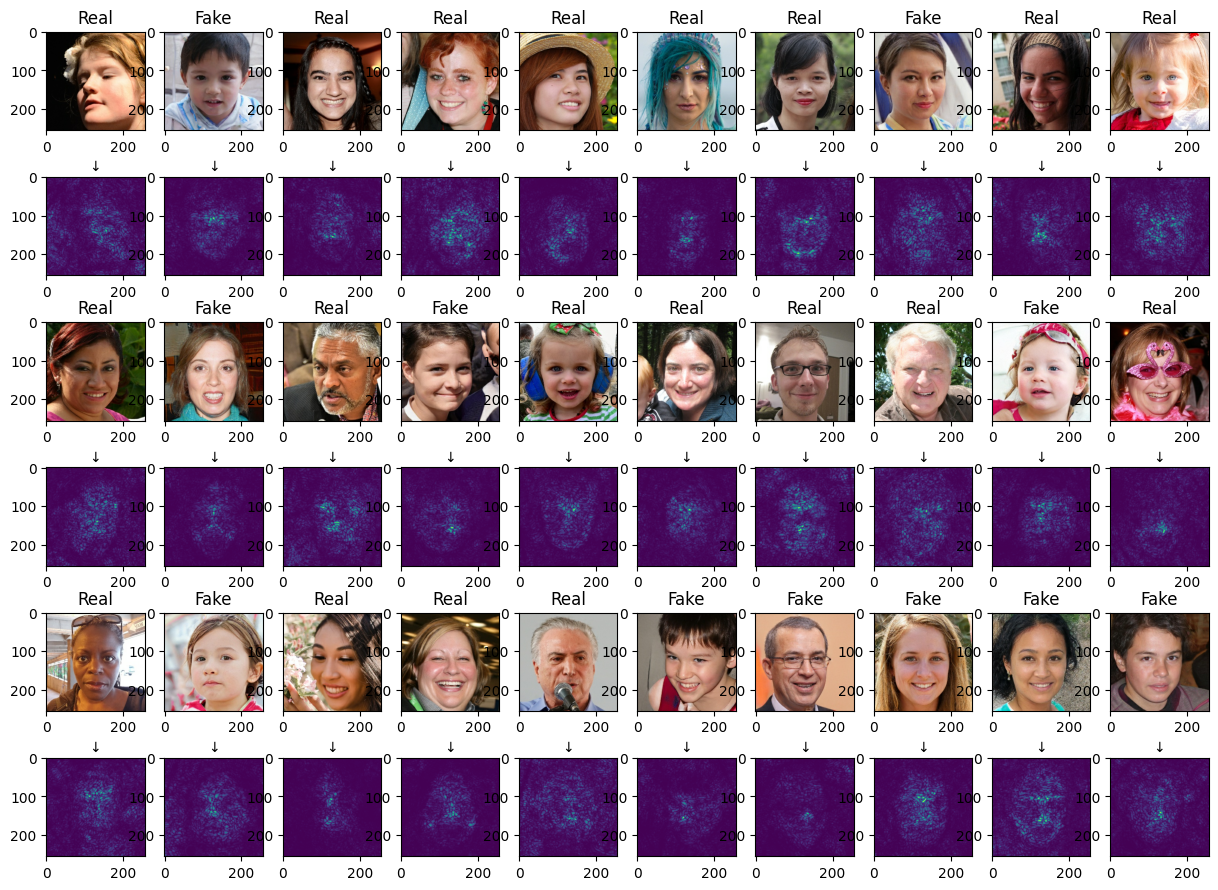

In [ ]:
fig, ax = plt.subplots(6, 10)
fig.set_size_inches(15, 11)

categories = ['Fake', 'Real']
for i in range(30):
  image = sample_images[i]/255.0
  label_idx = sample_labels[i]
  ax[2*(i//10)][i%10].imshow(image)
  ax[2*(i//10)][i%10].set_title(categories[label_idx])
  ax[2*(i//10)][i%10].set_xlabel('↓')
  ax[2*(i//10)+1][i%10].imshow(smaps[i])

### LIME Visualizer
The LIME Visualizer was used for explainability to determine what parts of the image are most important to the CNN. Results can be found in the report.

In [ ]:
def run_lime(model, image):

  explainer = lime_image.LimeImageExplainer()
  exp = explainer.explain_instance(
      image,
      model.predict,
      top_labels=5,
      hide_color=0,
      num_samples=1000)

  def generate_lime_image(exp, exp_class, pos_only = True, hide_background = True):

    image, mask = exp.get_image_and_mask(
        exp_class,
        positive_only=pos_only,
        num_features=5,
        hide_rest=hide_background)

    return mark_boundaries(image, mask)

  return generate_lime_image(exp, exp.top_labels[0], pos_only = False, hide_background = False)

In [ ]:
sample_images, sample_labels = [], []
for i, l in val_ds.take(1):
  sample_images, sample_labels = i, l

In [ ]:
fig, ax = plt.subplots(6, 10)
fig.set_size_inches(15, 11)

categories = ['Fake', 'Real']
for i in range(30):
  image = np.array(sample_images[i])/255.0
  label_idx = sample_labels[i]
  ax[2*(i//10)][i%10].imshow(image)
  ax[2*(i//10)][i%10].set_title(categories[label_idx])
  ax[2*(i//10)][i%10].set_xlabel('↓')
  ax[2*(i//10)][i%10].set_yticklabels([])
  ax[2*(i//10)][i%10].set_xticklabels([])
  ax[2*(i//10)+1][i%10].imshow(run_lime(fake_detector_model, image))
  ax[2*(i//10)+1][i%10].set_yticklabels([])
  ax[2*(i//10)+1][i%10].set_xticklabels([])

### Confusion Matrix
Used to determine the false negative rate compared to the false positive rate.

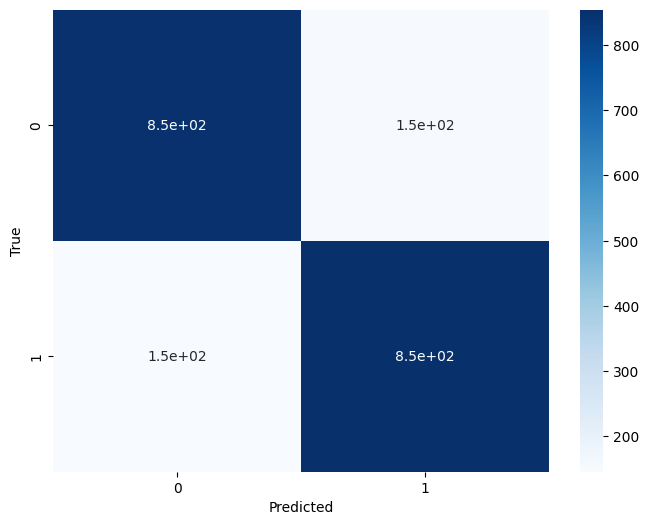

In [ ]:
def generate_confusion_matrix(model, data):
  prob_list = []
  label_list = []
  # Need to compute separately for each batch due to memeory
  for images_batch, labels_batch in data:
      probs = model(images_batch)
      prob_list.append(probs.numpy())
      label_list.append(labels_batch.numpy())
  # Combine results from each batch to compute final confusion matrix
  probabilities = np.concatenate(prob_list, axis=0)
  predictions = np.argmax(probabilities, axis=1)
  labels = np.concatenate(label_list, axis=0)

  # Compute final confusion matrix
  cm = confusion_matrix(labels, predictions)

  # Plot confusion matrix (use heatmap for visualization)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

generate_confusion_matrix(fake_detector_model, val_ds)